# Symmetrical Components

This notebook explores the computation of 3 symmetrical components (positive, negative, and zero) from an asymmetrical set of 3 phasors (A, B, and C) measured from the PMUs. Given voltage or current phasor components, $v_{abc}$ compute the symmetrical components $v_{012}$. 

See the [Symmetrical Components](https://en.wikipedia.org/wiki/Symmetrical_components) Wikipedia article for more information.


## Data Selection 

Using the `label` field of a stream's annotation, select the magnitude and angle for all three phases of either current or voltage. Note that the label field best describes the related streams in the Dominion dataset. For example consider the label "Loudoun Bus #5 115kV" - this label may be suffixed with "Ean" or "Ia", where "E" is equivalent to "V" for voltage, "I" is current, "a" is the phase, and "n" refers to "to neutral".

In [1]:
%matplotlib notebook

import btrdb
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from tabulate import tabulate
from btrdb.stream import StreamSet

In [2]:
db = btrdb.connect("api.dominion.predictivegrid.com:4411", "D00F502B4F844DD7F7E99FEB")
db.info()

{'majorVersion': 5, 'build': '5.5.1', 'proxy': {'proxyEndpoints': []}}

In [4]:
# Analysis Range 
START = "2019-05-14 13:50:00"
END = "2019-05-14 14:06:00"

# Analysis Version
VERSION = 0

# Loudoun Bus #5 115kV Voltage Phasors:
STREAM_UUIDS = [
    "7f7ccb3e-aedd-5d00-acf2-1de76cf83b68", # Phase A Voltage Magnitude
    "fd8b8c49-60fe-5ef4-85a5-f3d3f14a8f63", # Phase A Voltage Angle
    "1eb38881-0bee-5657-90e8-ae1845fff5b7", # Phase B Voltage Magnitude
    "ee75de90-956a-5283-a8d1-1f2cadbc2a7c", # Phase B Voltage Angle
    "7ed373ee-993c-56ef-b2bc-d5ab83ce203b", # Phase C Voltage Magnitude
    "a5a141e9-3905-5cf2-a011-7b9e613426ed", # Phase C Voltage Angle
]


def fetch_and_describe(*uuids, start=START, end=END):
    streams = db.streams(*uuids)
    table = [["Collection", "Label", "Phase", "Unit", "UUID"]]
    for stream in streams:
        tags = stream.tags()
        meta, _ = stream.annotations()
        table.append([
            stream.collection,
            meta.get("label", ""),
            meta.get("phase", ""),
            tags.get("unit", ""),
            str(stream.uuid),
        ])
    
    print(tabulate(table, headers="firstrow"))
    return streams.filter(start=start, end=end)


streams = fetch_and_describe(*STREAM_UUIDS)

Collection           Label                     Phase    Unit    UUID
-------------------  ------------------------  -------  ------  ------------------------------------
dfr/DFR!PMU-LOU3_93  Loudoun Bus #5 115kV Ean  A        VPHM    7f7ccb3e-aedd-5d00-acf2-1de76cf83b68
dfr/DFR!PMU-LOU3_93  Loudoun Bus #5 115kV Ean  A        VPHA    fd8b8c49-60fe-5ef4-85a5-f3d3f14a8f63
dfr/DFR!PMU-LOU3_93  Loudoun Bus #5 115kV Ebn  B        VPHM    1eb38881-0bee-5657-90e8-ae1845fff5b7
dfr/DFR!PMU-LOU3_93  Loudoun Bus #5 115kV Ebn  B        VPHA    ee75de90-956a-5283-a8d1-1f2cadbc2a7c
dfr/DFR!PMU-LOU3_93  Loudoun Bus #5 115kV Ecn  C        VPHM    7ed373ee-993c-56ef-b2bc-d5ab83ce203b
dfr/DFR!PMU-LOU3_93  Loudoun Bus #5 115kV Ecn  C        VPHA    a5a141e9-3905-5cf2-a011-7b9e613426ed


In [5]:
streams[0].tags()

{'name': 'DFR!PMU-LOU3_93-PM8', 'unit': 'VPHM', 'ingress': 'loudon_dfr_3'}

## Computation 

The streams selected above represent a single phasor group. The computation proceeds as follows:

1. For each phase, compute the complex stream from angle and magnitude
2. Compute the zero sequence component from the complex phases 
3. Compute the positive and negative sequence using the constants $\alpha$ and $\alpha^2$

In [4]:
def phase_filter(phase, streams):
    # This function replaces stream.filter(annotations={"phase": phase}) until bugfix
    vphm = None
    vpha = None 
    
    for stream in streams:
        tags = stream.tags()
        meta, _ = stream.annotations()
        
        if meta["phase"] == phase:
            if tags["unit"] == "VPHM":
                vphm = stream
            elif tags["unit"] == "VPHA":
                vpha = stream 
    
    if vphm is None or vpha is None:
        raise ValueError("could not find phase {phase} voltage magnitude or angle streams")
    
    phasor = StreamSet([vphm, vpha])
    phasor.filters = streams.filters
    return phasor


def complex_phasor(phase, streams=streams):
    # The below should work but there is currently a bug in the current version
    # phasor = streams.filter(annotations={"phase": phase})
    phasor = phase_filter(phase, streams)
    
    # Graph the voltage magnitude and angle for the specified phase
    vpha = phasor.filter(unit="VPHA").to_series()[0]
    vphm = phasor.filter(unit="VPHM").to_series()[0]
    
    # Raise an exception if the index is not identical 
    if not np.all(vpha.index==vphm.index):
        raise ValueError("mismatched time index in streams")
    
    r = (vphm * np.cos(np.radians(vpha))) # compute the real component
    i = (vphm * np.sin(np.radians(vpha))) # compute the imaginary component 
    
    # simplest way to create a complex numpy array is r + 1j * i
    return pd.Series(r + 1j * i, index=vpha.index, name=f"Complex Phase {phase}")


phA = complex_phasor("A")
phB = complex_phasor("B")
phC = complex_phasor("C")

In [5]:
ALPHA = np.complex(np.cos(np.radians(120)), np.sin(np.radians(120)))
ALPHA_2 = np.complex(np.cos(np.radians(240)), np.sin(np.radians(240)))


def zero_sequence(A, B, C):
    """
    Formula is (A + B + C) / 3.
    This is phasor math in complex plane.
    """
    # Series math keeps index
    return (A + B + C) / 3
    
    
def positive_sequence(A, B, C):
    """
    Formula is (A + B * 1<120 + C * 1<240) / 3
    ALPHA and ALPHA_2 are unit vectors at 120 degrees and -120 degrees, respectively.
    """
    # Series math keeps index
    return (A + B * ALPHA + C * ALPHA_2) / 3

    
def negative_sequence(A, B, C):
    """
    Formula is (A + B * 1<240 + C * 1<120) / 3
    """
    # Series math keeps index
    return (A + B * ALPHA_2 + C * ALPHA) / 3



c0 = zero_sequence(phA, phB, phC)
c1 = positive_sequence(phA, phB, phC)
c2 = negative_sequence(phA, phB, phC)

In [6]:
c0

2019-05-14 13:00:00.033332800     (-20013.395303147234+9447.241459422552j)
2019-05-14 13:00:00.066666800      (-20037.99621645204+9384.656695125806j)
2019-05-14 13:00:00.099999900     (-20068.356039593004+9323.563992565048j)
2019-05-14 13:00:00.133333000     (-20098.029049682827+9253.829846215634j)
2019-05-14 13:00:00.166666300     (-20134.697648626727+9184.744420454359j)
2019-05-14 13:00:00.200000100     (-20162.536807512715+9118.085288683493j)
2019-05-14 13:00:00.233333100      (-20195.84761642889+9048.801821770077j)
2019-05-14 13:00:00.266666200       (-20221.92516212882+8981.47922704456j)
2019-05-14 13:00:00.299999900     (-20255.253907247774+8910.457565173001j)
2019-05-14 13:00:00.333333300     (-20287.955156053584+8833.603830284374j)
2019-05-14 13:00:00.366666300      (-20313.48539934471+8768.271528094025j)
2019-05-14 13:00:00.399999600     (-20342.763062715465+8701.004963510317j)
2019-05-14 13:00:00.433333400     (-20370.901018756478+8634.268466166564j)
2019-05-14 13:00:00.46666

In [7]:
c1

2019-05-14 13:00:00.033332800     (18186.09863724031+12614.064268795693j)
2019-05-14 13:00:00.066666800    (18144.069244951155+12665.438908824093j)
2019-05-14 13:00:00.099999900      (18105.896590385655+12721.8556584138j)
2019-05-14 13:00:00.133333000    (18061.683864598705+12781.934516146883j)
2019-05-14 13:00:00.166666300     (18017.70762361311+12848.246915791406j)
2019-05-14 13:00:00.200000100    (17975.291695646756+12907.340933114141j)
2019-05-14 13:00:00.233333100     (17931.516348219862+12968.65802905513j)
2019-05-14 13:00:00.266666200     (17886.77870018515+13027.631286775455j)
2019-05-14 13:00:00.299999900    (17841.763127894927+13090.275042772651j)
2019-05-14 13:00:00.333333300     (17792.286918194364+13157.51647753438j)
2019-05-14 13:00:00.366666300    (17748.943869979023+13212.702780723966j)
2019-05-14 13:00:00.399999600    (17704.081912870868+13271.656502032894j)
2019-05-14 13:00:00.433333400    (17660.458759562844+13329.249488717587j)
2019-05-14 13:00:00.466666500      (17

In [8]:
c2

2019-05-14 13:00:00.033332800      (1827.610581584326-22060.200504384957j)
2019-05-14 13:00:00.066666800     (1894.5800544287372-22049.907806495794j)
2019-05-14 13:00:00.099999900     (1961.6642966513957-22045.575707235585j)
2019-05-14 13:00:00.133333000      (2036.9657147398761-22036.67413166498j)
2019-05-14 13:00:00.166666300       (2114.12814349923-22033.711719848383j)
2019-05-14 13:00:00.200000100     (2187.6159355548534-22024.813989596096j)
2019-05-14 13:00:00.233333100       (2264.527208172712-22018.49429624444j)
2019-05-14 13:00:00.266666200     (2335.6949616262655-22007.475242621796j)
2019-05-14 13:00:00.299999900       (2413.56899984492-22000.933975025084j)
2019-05-14 13:00:00.333333300     (2495.8113679266485-21991.088342096504j)
2019-05-14 13:00:00.366666300      (2565.7861234162456-21981.87316241583j)
2019-05-14 13:00:00.399999600     (2639.7333814229096-21972.960434682493j)
2019-05-14 13:00:00.433333400     (2710.1361189687445-21964.140832455832j)
2019-05-14 13:00:00.46666

<IPython.core.display.Javascript object>


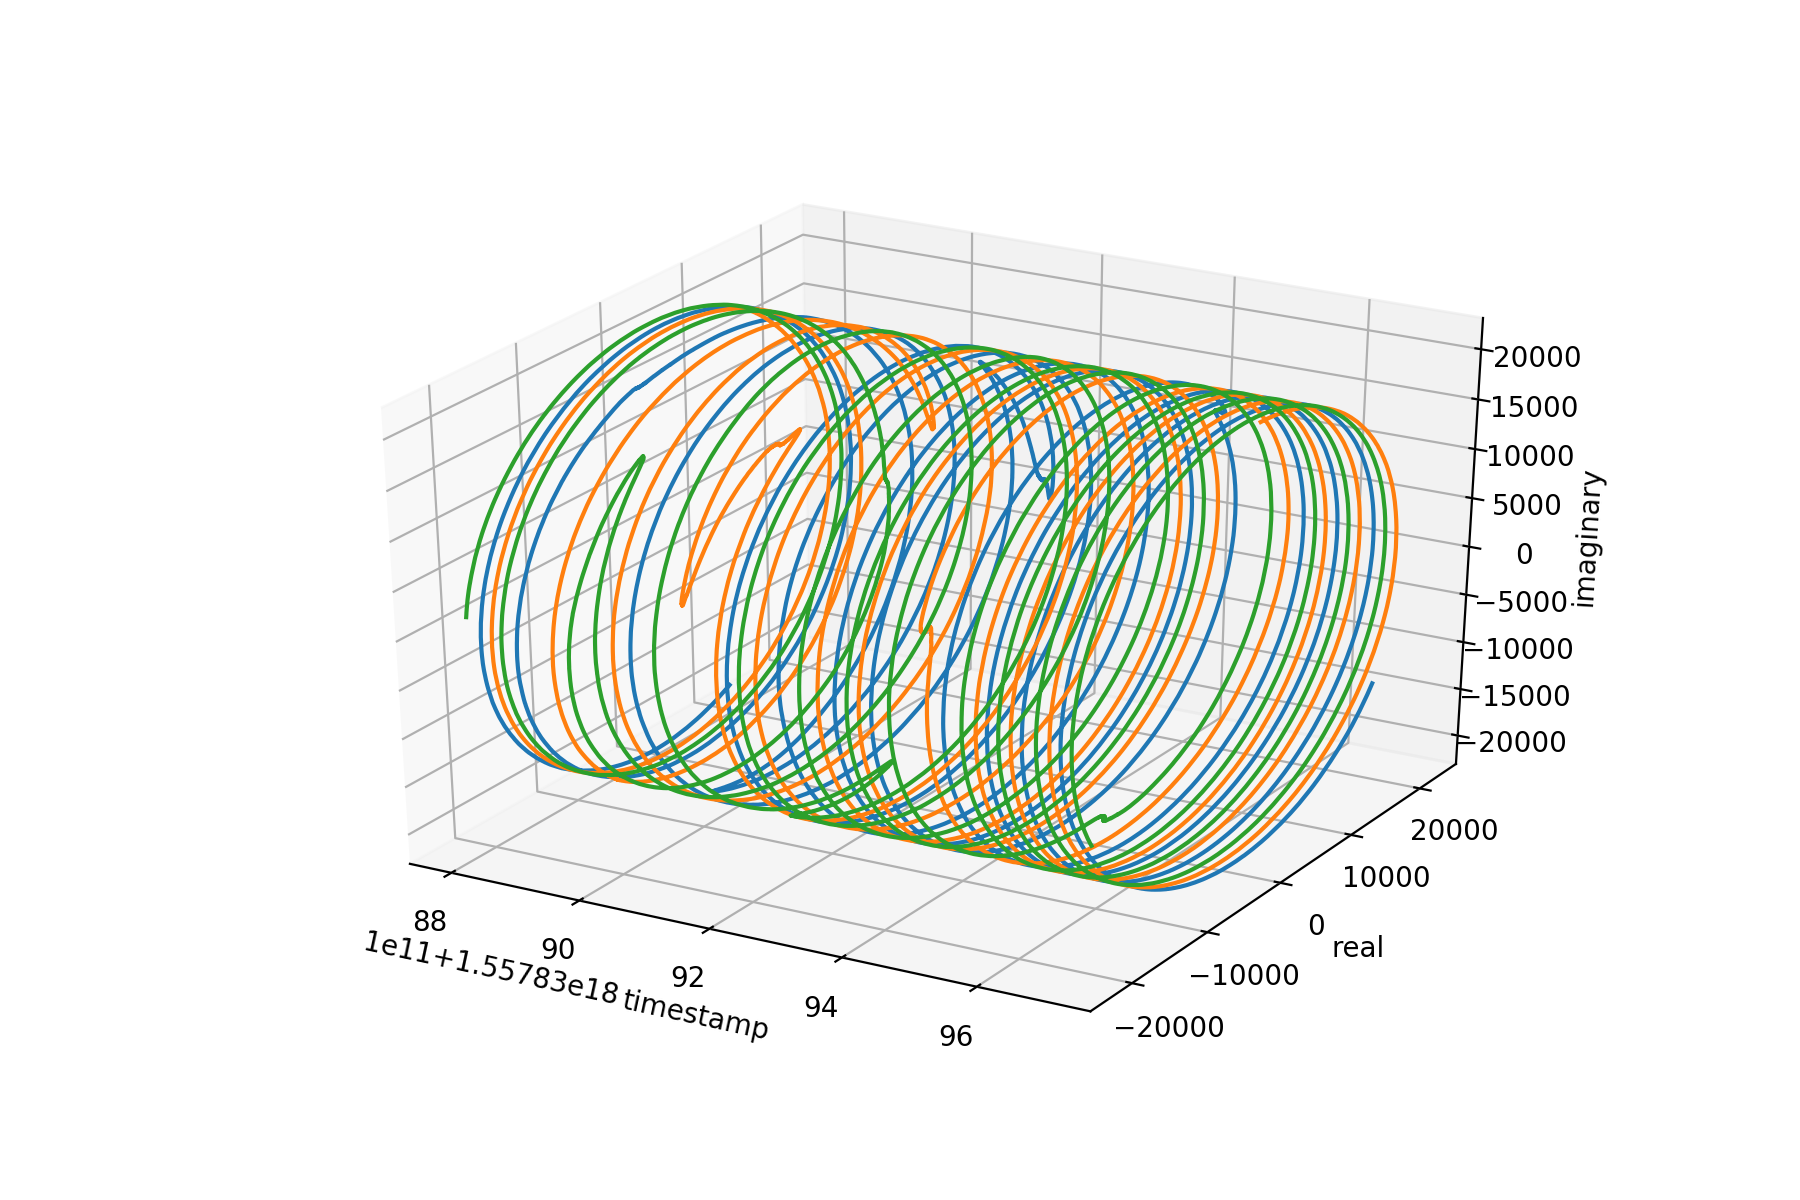

In [19]:
def complex_timeseries_3d_plot(s, label=None, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
    
    ax.plot(s.index.astype(np.int64), s.imag, s.real, label=label)

    ax.set_xlabel("timestamp")
    ax.set_ylabel("real")
    ax.set_zlabel("imaginary")
    
    return ax 


ax = complex_timeseries_3d_plot(c0, "zero component")
complex_timeseries_3d_plot(c1, "positive component", ax=ax)
complex_timeseries_3d_plot(c2, "negative component", ax=ax)

<IPython.core.display.Javascript object>


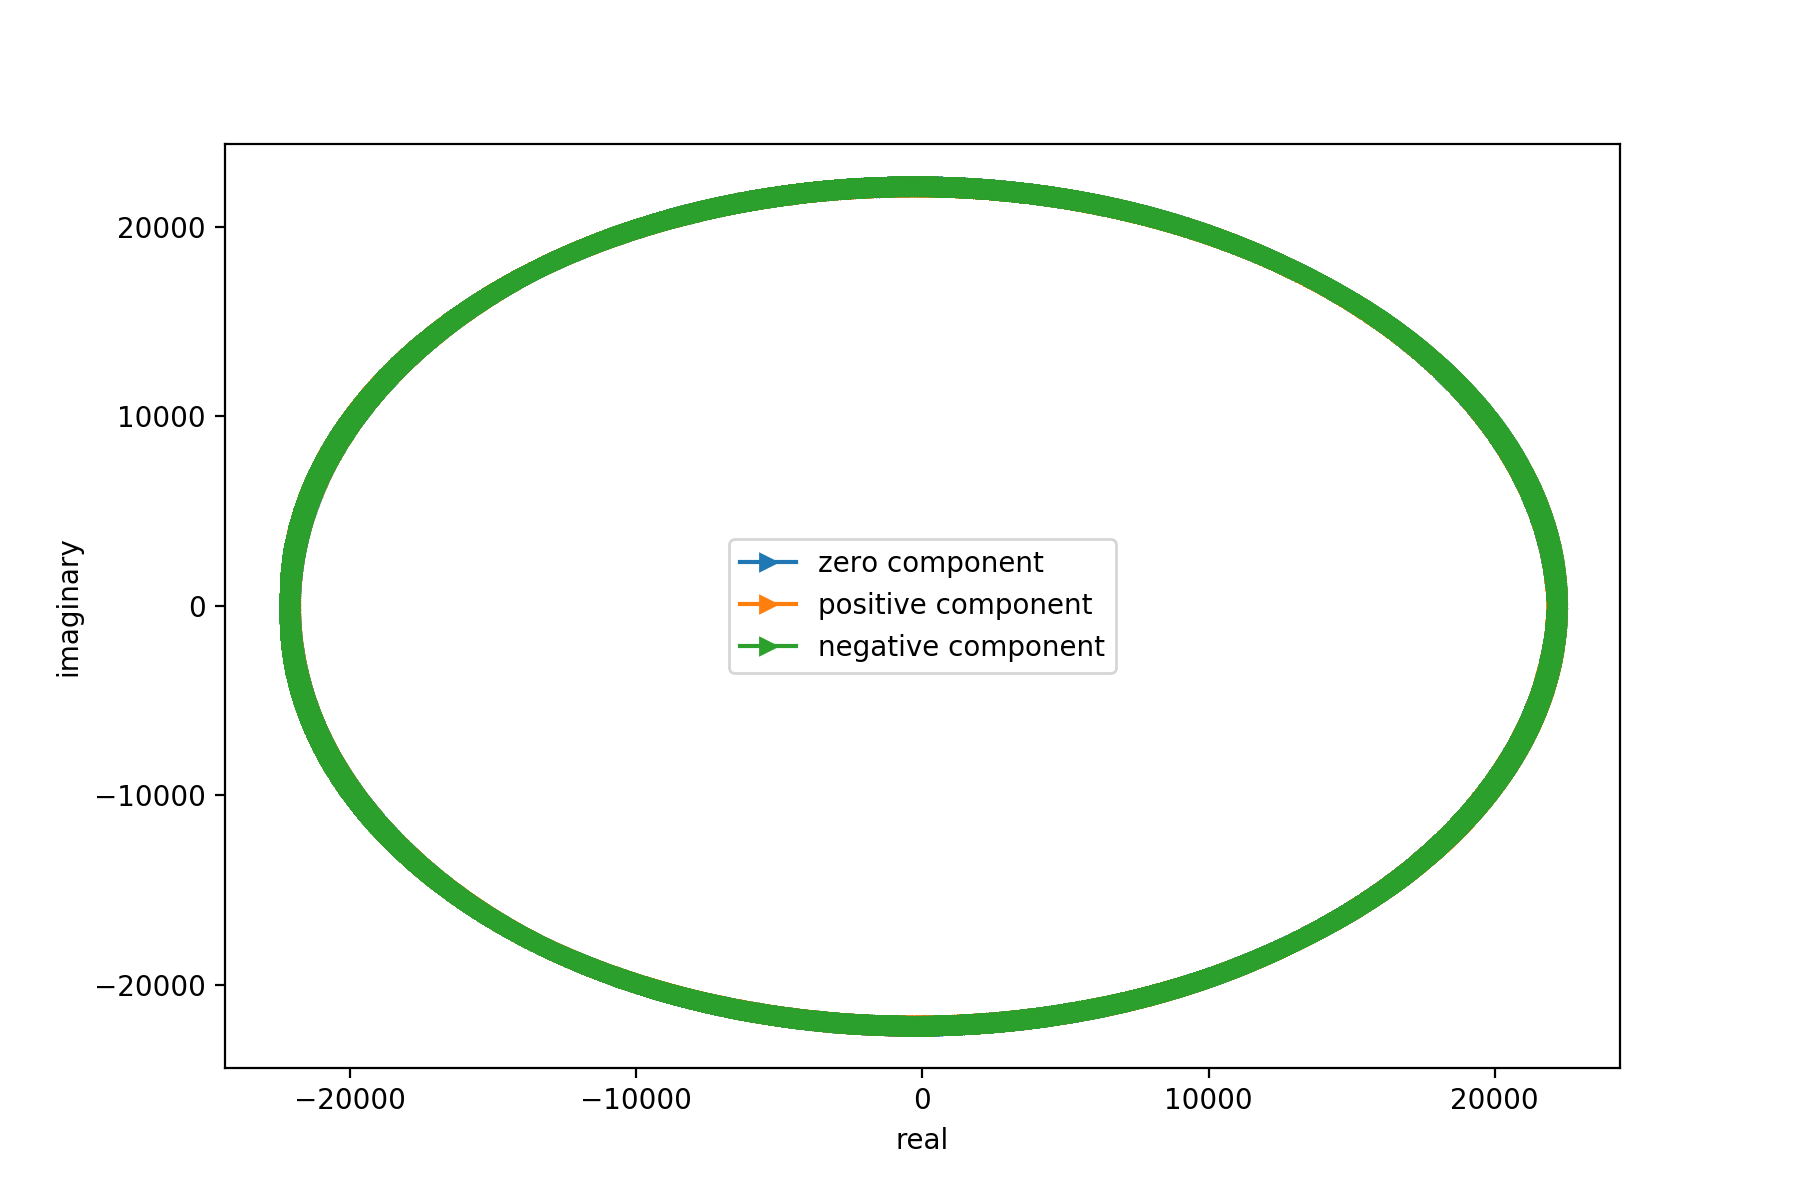

In [22]:
def complex_timeseries(s, label=None, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(9,6))
    
    
    ax.plot(s.real, s.imag, label=label, marker=">")
    ax.set_xlabel("real")
    ax.set_ylabel("imaginary")
    
    return ax


ax = complex_timeseries(c0, label="zero component")
complex_timeseries(c1, label="positive component", ax=ax)
complex_timeseries(c2, label="negative component", ax=ax)
ax.legend()